# Домашнее задание 6.
# Двухуровневые модели рекомендаций

In [1]:
#импорт необходимых библиотек и модулей
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
#from metrics import precision_at_k, recall_at_k
#from utils import prefilter_items
#from recommenders import MainRecommender

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

[0. Загрузка данных](#part0) 

[1. Задание №1](#part1) 

[2. Задание №2](#part2) 

## 0. Загрузка данных <a class="anchor" id="part0"></a><center>

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing (названия столбцов переводим в нижний регистр)
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

#данные для обучения первой модели
data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]

#данные для валидации первой модели
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

#данные для обучения второй модели
data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

#данные для теста первой и второй модели
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
#предобработка данных
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data['user_id'].nunique()} Items: {df_data['item_id'].nunique()}")

In [5]:
# warm-start
common_users = list(set(data_train_lvl_1.user_id.values)&(set(data_val_lvl_1.user_id.values))&set(data_val_lvl_2.user_id.values))

data_train_lvl_1 = data_train_lvl_1[data_train_lvl_1.user_id.isin(common_users)]
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]

print_stats_data(data_train_lvl_1,'train_lvl_1')
print_stats_data(data_val_lvl_1,'val_lvl_1')
print_stats_data(data_train_lvl_2,'train_lvl_2')
print_stats_data(data_val_lvl_2,'val_lvl_2')

train_lvl_1
Shape: (998901, 13) Users: 1915 Items: 5001
val_lvl_1
Shape: (163261, 12) Users: 1915 Items: 27118
train_lvl_2
Shape: (163261, 12) Users: 1915 Items: 27118
val_lvl_2
Shape: (115989, 12) Users: 1915 Items: 24042


In [6]:
#создаем элемент класса
recommender = MainRecommender(data_train_lvl_1)

Варианты поиска возможных кандидатов в рекомендации для user_id = 2375. Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [7]:
recommender.get_als_recommendations(2375, N=200)[:5]

[871756, 925862, 944534, 1116589, 883932]

In [8]:
recommender.get_own_recommendations(2375, N=200)[:5]

[1036501, 887219, 918046, 9802981, 847962]

In [9]:
recommender.get_similar_items_recommendation(2375, N=200)[:5]

[1127716, 864774, 5564906, 1115576, 918335]

In [10]:
recommender.get_similar_users_recommendation(2375, N=200)[:5]

[985055, 935527, 1136341, 868161, 907308]

## Задание №1 <a class="anchor" id="part1"></a><center>

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

### A) посчитаем значения  recall@k для возможных кандидатов в рекомендации

In [11]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [12]:
result_lvl_1['als_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
als_recommendations_metric = result_lvl_1.apply(lambda row: recall_at_k(row['als_recommendations'], row['actual'], 50), axis=1).mean()

In [13]:
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
own_recommendations_metric = result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual'], 50), axis=1).mean()

In [14]:
result_lvl_1['similar_items_recommendation'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
similar_items_recommendation_metric = result_lvl_1.apply(lambda row: recall_at_k(row['similar_items_recommendation'], row['actual'], 50), axis=1).mean()

In [15]:
result_lvl_1['similar_users_recommendation'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))
similar_users_recommendation_metric = result_lvl_1.apply(lambda row: recall_at_k(row['similar_users_recommendation'], row['actual'], 50), axis=1).mean()

In [16]:
result_lvl_1.head(2)

,user_id,actual,als_recommendations,own_recommendations,similar_items_recommendation,similar_users_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[885290, 9296957, 6534030, 1104349, 960732, 10...","[856942, 9297615, 5577022, 1074612, 9655212, 1...","[871754, 9526410, 5582712, 9297615, 5577022, 1...","[1028166, 898847, 898121, 9802981, 1136341, 83..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[1042616, 910439, 928146, 1084036, 1127732, 10...","[13003092, 995598, 5570685, 6979393, 1084036, ...","[948650, 948650, 889731, 10455579, 845715, 863...","[1056212, 1113675, 970160, 897611, 923169, 101..."


In [17]:
metrics_result = pd.DataFrame({'als_recommendations': [als_recommendations_metric],
                               'own_recommendations': [own_recommendations_metric],
                               'similar_items_recommendation': [similar_items_recommendation_metric],
                               'similar_users_recommendation': [similar_users_recommendation_metric]
                              }, 
                              index = {'recall@50'})
metrics_result

,als_recommendations,own_recommendations,similar_items_recommendation,similar_users_recommendation
recall@50,0.037006,0.063585,0.022182,0.007414


In [18]:
print('Вывод: ')
print(f'Лучшее значение метрики recall@50 = {max(metrics_result.values[0])} у {[column for column in metrics_result.columns.tolist() if metrics_result[column].values[0] == max(metrics_result.values[0])][0]}')

Вывод: 
Лучшее значение метрики recall@50 = 0.06358452263580718 у own_recommendations


### B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [19]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [20]:
own_recommendations_metrics = []

for k in [20,50,100,200,500]:
    result_lvl_1[f'own_recommendations_k={k}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))
    own_recommendations_metric = result_lvl_1.apply(lambda row: recall_at_k(row[f'own_recommendations_k={k}'], row['actual'], k), axis=1).mean()
    own_recommendations_metrics.append(own_recommendations_metric)

result_lvl_1

,user_id,actual,own_recommendations_k=20,own_recommendations_k=50,own_recommendations_k=100,own_recommendations_k=200,own_recommendations_k=500
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 1074612, 9655212, 1...","[856942, 9297615, 5577022, 1074612, 9655212, 1...","[856942, 9297615, 5577022, 1074612, 9655212, 1...","[856942, 9297615, 5577022, 1074612, 9655212, 1...","[856942, 9297615, 5577022, 1074612, 9655212, 1..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 995598, 5570685, 6979393, 1084036, ...","[13003092, 995598, 5570685, 6979393, 1084036, ...","[13003092, 995598, 5570685, 6979393, 1084036, ...","[13003092, 995598, 5570685, 6979393, 1084036, ...","[13003092, 995598, 5570685, 6979393, 1084036, ..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[894360, 7147142, 840386, 974548, 896666, 5570...","[894360, 7147142, 840386, 974548, 896666, 5570...","[894360, 7147142, 840386, 974548, 896666, 5570...","[894360, 7147142, 840386, 974548, 896666, 5570...","[894360, 7147142, 840386, 974548, 896666, 5570..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101...","[981660, 919963, 1021715, 969932, 950615, 6463...","[981660, 919963, 1021715, 969932, 950615, 6463...","[981660, 919963, 1021715, 969932, 950615, 6463...","[981660, 919963, 1021715, 969932, 950615, 6463...","[981660, 919963, 1021715, 969932, 950615, 6463..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1...","[918046, 9655676, 9707147, 862799, 1098910, 90...","[918046, 9655676, 9707147, 862799, 1098910, 90...","[918046, 9655676, 9707147, 862799, 1098910, 90...","[918046, 9655676, 9707147, 862799, 1098910, 90...","[918046, 9655676, 9707147, 862799, 1098910, 90..."
...,...,...,...,...,...,...,...
1910,2496,"[831509, 867188, 1013623, 1048851, 5592734, 16...","[1134296, 1029112, 865196, 971660, 865511, 862...","[1134296, 1029112, 865196, 971660, 865511, 862...","[1134296, 1029112, 865196, 971660, 865511, 862...","[1134296, 1029112, 865196, 971660, 865511, 862...","[1134296, 1029112, 865196, 971660, 865511, 862..."
1911,2497,"[820291, 824759, 838797, 859010, 859075, 86077...","[1066685, 1117219, 938139, 852521, 1010950, 86...","[1066685, 1117219, 938139, 852521, 1010950, 86...","[1066685, 1117219, 938139, 852521, 1010950, 86...","[1066685, 1117219, 938139, 852521, 1010950, 86...","[1066685, 1117219, 938139, 852521, 1010950, 86..."
1912,2498,"[865511, 962991, 1076374, 1102358, 5564901, 15...","[1022066, 1076580, 5565356, 1100379, 968759, 9...","[1022066, 1076580, 5565356, 1100379, 968759, 9...","[1022066, 1076580, 5565356, 1100379, 968759, 9...","[1022066, 1076580, 5565356, 1100379, 968759, 9...","[1022066, 1076580, 5565356, 1100379, 968759, 9..."
1913,2499,"[861282, 921744, 1050968, 13842089, 828837, 86...","[5568964, 6904613, 1131312, 5570048, 889989, 1...","[5568964, 6904613, 1131312, 5570048, 889989, 1...","[5568964, 6904613, 1131312, 5570048, 889989, 1...","[5568964, 6904613, 1131312, 5570048, 889989, 1...","[5568964, 6904613, 1131312, 5570048, 889989, 1..."


In [21]:
own_recommendations_metrics

[0.04035775664889501,
 0.06358452263580718,
 0.08883590802384353,
 0.11857838766134818,
 0.15851638681749888]

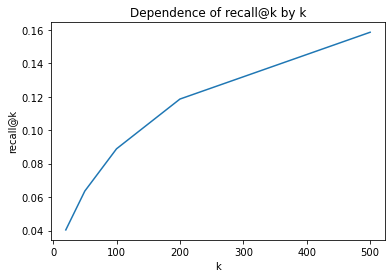

In [22]:
x = [20,50,100,200,500]
y = own_recommendations_metrics
plt.plot(x,y)
plt.title("Dependence of recall@k by k")
plt.xlabel("k")
plt.ylabel("recall@k")
plt.show()

**Вывод:** с увеличением k recall@k монотонно возрастает.

### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Оптимальное количество рекомендаций (точка, где график recall@k перестает резко возрастать) равно 200. Однако, для покупателя такое количество рекомендаций является слишком большим. Целесообразно покупателям предлагать 5 товаров в качестве рекомендаций.

## 2. Задание №2. <a class="anchor" id="part2"></a><center>

Обучите модель 2-ого уровня, при этом:
    
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    
    - Вырос ли precision@5 при использовании двухуровневой модели?

### A) Подготавливаем выбранных кандидатов для обучения:
- *Для примера* сгенерируем топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [23]:
#берем пользователей из data_train_lvl_2 для ранжирования
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

#собираем выбранных кандидатов
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [24]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[834103, 1119399, 944588, 1107824, 9802981, 10..."
1,2021,"[950935, 1119454, 1019142, 835578, 863762, 102..."


In [25]:
#"развернем" таблицу, чтобы каждый кандидат был один в строке (чтобы к нему добавть таргет)
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)

users_lvl_2.head(4)

,user_id,item_id
0,2070,834103
0,2070,1119399
0,2070,944588
0,2070,1107824


In [26]:
users_lvl_2['user_id'].nunique() #количество уникальных пользователей

1915

In [27]:
#создаем датасет для ранжирования (для обучения модели второго уровня)
#на каждого юзера по 50 кандидатов
#Обучаем модель 2-ого уровня на data_train_lvl_2 и *только* на выбранных кандидатах!!!

targets_lvl_2= data_train_lvl_2[['user_id', 'item_id']].copy()

targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

targets_lvl_2.head(4)

,user_id,item_id,target
0,2070,834103,1.0
1,2070,834103,1.0
2,2070,834103,1.0
3,2070,834103,1.0


In [28]:
#доля купленных товаров среди кандидатов
targets_lvl_2['target'].mean()

0.1251064256022437

### B) Подготовка фичей для обучения модели

In [29]:
#генерируем новые признаки из датасета data_train_lvl_2
data_train_lvl_2.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0


In [30]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [31]:
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


Функии для построения новых признаков

In [32]:
#Фичи user_id
def new_user_features(data, user_features, item_features):
    
    new_user_features = user_features.merge(data, on='user_id', how='left')
    new_item_features = data.merge(item_features, on='item_id', how='left')
    
    #Средний чек
    average_check = new_user_features.groupby(['user_id'])['sales_value'].mean().reset_index()
    average_check.rename(columns={'sales_value': 'average_sales_value'}, inplace=True)
    user_features = user_features.merge(average_check)

     
    #Количество уникальных категорий покупателя
    num_unique_department = new_item_features.groupby(['user_id'])['department'].nunique().reset_index()
    num_unique_department.rename(columns={'department': 'num_unique_department'}, inplace=True)
    user_features = user_features.merge(num_unique_department, on='user_id', how='left')
    
   
    #Количество покупок в каждой категории
    num_sales_in_category = new_item_features[['user_id', 'quantity', 'department']].groupby(['user_id', 'department']).sum().reset_index()
    num_sales_in_category.rename(columns={'quantity': 'num_quantity'}, inplace=True) 
    num_sales_in_category.drop(labels=[0], axis=0,inplace=True)

    users_num_cat_sales_dict = {}
    for user_id in num_sales_in_category['user_id'].unique():
        users_num_cat_sales_dict[user_id] = dict(list(zip(num_sales_in_category[num_sales_in_category['user_id']==user_id]['department'].values, \
                                                      num_sales_in_category[num_sales_in_category['user_id']==user_id]['num_quantity'].values)))

    for cat in item_features['department'].unique():
        new_item_features[f'num_sales_in_{cat}'] = 0

    for user_id in new_item_features['user_id'].unique():
        for cat in users_num_cat_sales_dict[user_id].keys():
            new_item_features.loc[(new_item_features['user_id']==user_id) & (new_item_features['department']==cat), f'num_sales_in_{cat}']=\
            users_num_cat_sales_dict[user_id][cat]

    feat_to_merge = ['user_id'] + new_item_features.columns.tolist()[18:]
    user_num_sales_in_cat = new_item_features[feat_to_merge]
    user_num_sales_in_cat = user_num_sales_in_cat.groupby('user_id').max().reset_index()
    user_features = user_features.merge(user_num_sales_in_cat, on='user_id', how='left')
    
    user_features = user_features.replace(np.nan, 0)
    user_features = user_features.drop('num_sales_in_ ', axis=1)
    
    return user_features

In [33]:
%%time

user_features_new = new_user_features(data_train_lvl_2, user_features, item_features)
user_features_new.head(3)

Wall time: 1min 53s


,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,average_sales_value,num_unique_department,...,num_sales_in_DELI/SNACK BAR,num_sales_in_PORK,num_sales_in_AUTOMOTIVE,num_sales_in_VIDEO RENTAL,num_sales_in_CNTRL/STORE SUP,num_sales_in_HOUSEWARES,num_sales_in_POSTAL CENTER,num_sales_in_PHOTO,num_sales_in_VIDEO,num_sales_in_PHARMACY SUPPLY
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.569774,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.085000,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,2.472683,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Фичи item_id
def new_item_features(data, user_features, item_features):
    
    new_item_features = item_features.merge(data, on='item_id', how='left')
    
    # Цена
    price = new_item_features.groupby('item_id')['sales_value'].sum() \
                            / new_item_features.groupby('item_id')['quantity'].sum()
    price = price.groupby('item_id').mean().reset_index()
    price.columns = ['item_id', 'price']
    price['price'].fillna(0, inplace= True)
    item_features = item_features.merge(price)

    #Среднее число покупок товара в неделю
    num_purchase_week = data.groupby(['item_id']).agg({'week_no': 'nunique', 'quantity': 'sum'}).reset_index()
    num_purchase_week['average_num_purchases_week'] = num_purchase_week['quantity'] / num_purchase_week['week_no']
    average_num_purchases_week = num_purchase_week[['item_id', 'average_num_purchases_week']]
    item_features = item_features.merge(average_num_purchases_week, on='item_id', how='left')
    item_features['average_num_purchases_week'].fillna(0, inplace= True)
    
    #Средняя цена товара в категории
    average_price_in_cat = item_features.groupby(['department'])['price'].mean().reset_index()
    average_price_in_cat.rename(columns={'price': 'average_price_in_dep'}, inplace=True)
    average_price_in_cat.drop(labels=[0], axis=0,inplace=True)
    item_features = item_features.merge(average_price_in_cat)
    
    #Цена товара/средняя цена товара в категории
    item_features['price/average_price_in_dep'] = item_features['price'] / item_features['average_price_in_dep']
    
    #Средняя цена товара в категории - Цена товара
    item_features['average_price_in_dep - item_price'] = item_features['average_price_in_dep'] - item_features['price']

    return item_features

In [35]:
%%time

item_features_new = new_item_features(data_train_lvl_2, user_features, item_features)
item_features_new.head(3)

Wall time: 270 ms


,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price,average_num_purchases_week,average_price_in_dep,price/average_price_in_dep,average_price_in_dep - item_price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.0,0.0,1.043754,0.0,1.043754
1,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,0.0,0.0,1.043754,0.0,1.043754
2,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,0.0,0.0,1.043754,0.0,1.043754


Объединяем два датасета с новыми признаками

In [36]:
targets_lvl_2 = targets_lvl_2.merge(item_features_new, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features_new, on='user_id', how='left')

targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price,...,num_sales_in_DELI/SNACK BAR,num_sales_in_PORK,num_sales_in_AUTOMOTIVE,num_sales_in_VIDEO RENTAL,num_sales_in_CNTRL/STORE SUP,num_sales_in_HOUSEWARES,num_sales_in_POSTAL CENTER,num_sales_in_PHOTO,num_sales_in_VIDEO,num_sales_in_PHARMACY SUPPLY
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### C) Обучение модели ранжирования (второго уровня)

In [37]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]
X_train.shape, y_train.shape

((99835, 65), (99835, 1))

In [38]:
cat_feats = X_train.columns[2:8].tolist() + X_train.columns[13:20].tolist()

X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [39]:
%%time

lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Wall time: 2.01 s


LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'age_desc',
                                   'marital_status_code', 'income_desc',
                                   'homeowner_desc', 'hh_comp_desc',
                                   'household_size_desc', 'kid_category_desc'],
               learning_rate=0.05, max_depth=8, n_estimators=300,
               objective='binary')

In [40]:
def test_X_y_prepare(data, item_features_new, user_features_new):
    test_users_lvl_2 = pd.DataFrame(data['user_id'].unique())
    test_users_lvl_2.columns = ['user_id']
    
    test_users = data['user_id'].unique()
    test_users_lvl_2 = test_users_lvl_2[test_users_lvl_2['user_id'].isin(test_users)]

    test_users_lvl_2['candidates'] = test_users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

    s = test_users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'

    test_users_lvl_2 = test_users_lvl_2.drop('candidates', axis=1).join(s)
    
    test_users_lvl_2['flag'] = 1

    test_lvl_2 = data[['user_id', 'item_id']].copy()
    
    test_lvl_2['target'] = 1  
    
    test_lvl_2 = test_users_lvl_2.merge(test_lvl_2, on=['user_id', 'item_id'], how='left')

    test_lvl_2['target'].fillna(0, inplace= True)
    test_lvl_2.drop('flag', axis=1, inplace=True)
    
    test_lvl_2 = test_lvl_2.merge(item_features_new, on='item_id', how='left')
    test_lvl_2 = test_lvl_2.merge(user_features_new, on='user_id', how='left')

    X = test_lvl_2.drop('target', axis=1)
    y = test_lvl_2[['target']]
    
    return X, y

In [41]:
%%time

test_item_features_new = new_item_features(data_val_lvl_2, user_features, item_features)
test_user_features_new = new_user_features(data_val_lvl_2, user_features, item_features)

Wall time: 1min 9s


In [42]:
X_test, y_test = test_X_y_prepare(data_val_lvl_2, test_item_features_new, test_user_features_new)
X_test[cat_feats] = X_test[cat_feats].astype('category')
X_test.shape, y_test.shape

((97508, 65), (97508, 1))

In [43]:
test_preds_proba = lgb.predict_proba(X_test)[:, 1]
test_preds_proba

array([0.16516855, 0.16516855, 0.03759564, ..., 0.03427044, 0.08288554,
       0.02528547])

### D) Оценка качества модели на тестовом датасете

In [44]:
result_eval_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_eval_lvl_2.columns=['user_id', 'actual']
result_eval_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


Оценка модели первого уровня на тестовом датасете

In [45]:
%%time

result_eval_lvl_2['own_rec'] = result_eval_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

Wall time: 5.82 s


In [46]:
# precision@5 модели первого уровня на тестовом датасете
own_recommendations_metric_test = result_eval_lvl_2.apply(lambda row: precision_at_k(row[f'own_rec'], row['actual'], 5), axis=1).mean()
own_recommendations_metric_test

0.16616187989555986

Оценка модели второго уровня на тестовом датасете

In [47]:
def lvl_2_recommendations(X_test, test_preds_proba, data_val_lvl_2):
    X_test['predict_proba'] = test_preds_proba
    
    X_test.sort_values(['user_id', 'predict_proba'], ascending=False, inplace=True)

    result = X_test.groupby('user_id').head(5)

    recs = result.groupby('user_id')['item_id']
    recomendations = []
    for user, preds in recs:
        recomendations.append({'user_id': user, 'ranked_own_rec': preds.tolist()})

    recomendations = pd.DataFrame(recomendations)

    result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
    result_lvl_2.columns=['user_id', 'actual']

    result_lvl_2 = result_lvl_2.merge(recomendations)
    
    return result_lvl_2

In [48]:
result_lvl_2 = lvl_2_recommendations(X_test, test_preds_proba, data_val_lvl_2)
result_lvl_2

,user_id,actual,ranked_own_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9527558, 8293439, 8293439, 934369, 8091601]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1098844, 1108094, 878715, 1084036, 12757544]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1122358, 1122358, 1122358, 12731436, 916575]"
3,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[969932, 983795, 1115577, 1013503, 1090507]"
4,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1082212, 6553737, 868015, 6534030, 982493]"
...,...,...,...
1910,2496,[6534178],"[953539, 1006664, 996269, 865511, 1082544]"
1911,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[942817, 1031316, 864279, 1066685, 849202]"
1912,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1100379, 851101, 1076580, 918907, 849578]"
1913,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[901460, 6904613, 7166863, 937626, 919766]"


In [49]:
# precision@5 модели второго уровня на тестовом датасете
ranked_own_recommendations_metric_test = result_lvl_2.apply(lambda row: precision_at_k(row[f'ranked_own_rec'], row['actual'], 5), axis=1).mean()
ranked_own_recommendations_metric_test

0.19895561357702238

Сводная таблица precision@5 для моделей 1-го уровня и 2-х уровневой модели на test

In [50]:
metrics_result = pd.DataFrame({'own_rec': [own_recommendations_metric_test],
                               'ranked_own_rec': [ranked_own_recommendations_metric_test]}, 
                              index = {'precision@5'})
metrics_result

,own_rec,ranked_own_rec
precision@5,0.166162,0.198956


**Вывод:** precision@5 при использовании 2-х уровневой модели вырос. Следовательно, новые признаки оказались полезны.